In [20]:
import numpy as np
from sklearn.model_selection import train_test_split, train_test_split
import pandas as pd

import utils.load_data as ld
import utils.classifiers as clfs
import utils.features as f

In [21]:
data_type = 'init'
label_type = 'pss'
#time_series_features, fractal_features, entropy_features, hjorth_features, freq_band_features, kymatio_wave_scattering
feature_type = f.time_series_features
kfold = True


train_data, test_data, train_labels, test_labels = ld.load_and_shape_data(data_type, label_type, feature_type, kfold)

---- Generating all recordings ----
All records generated

---- Filtering out invalid recordings ----
ERROR 1) Failed to read data for recording P006_S002_001
ERROR 1) Failed to read data for recording P006_S002_002
ERROR 1) Failed to read data for recording P010_S001_001
ERROR 1) Failed to read data for recording P013_S001_001
ERROR 1) Failed to read data for recording P013_S001_002
ERROR 1) Failed to read data for recording P020_S001_001
ERROR 1) Failed to read data for recording P023_S002_002
ERROR 1) Failed to read data for recording P028_S002_001
ERROR 1) Failed to read data for recording P028_S002_002

---- Returning valid recordings ----
['P001_S001_001', 'P001_S001_002', 'P001_S002_001', 'P001_S002_002', 'P002_S001_001', 'P002_S001_002', 'P002_S002_001', 'P002_S002_002', 'P003_S001_001', 'P003_S001_002', 'P003_S002_001', 'P003_S002_002', 'P004_S001_001', 'P004_S001_002', 'P004_S002_001', 'P004_S002_002', 'P005_S001_001', 'P005_S001_002', 'P005_S002_001', 'P005_S002_002', 'P006_

init data with <function time_series_features at 0x13a321e10> features and pss labels
KNeighborsClassifier(leaf_size=1, n_neighbors=1)
{'leaf_size': 1, 'n_neighbors': 1, 'p': 2}
Number of results: 72
accuracies: [0.83125  0.859375 0.81875  0.81875  0.81875  0.825    0.803125 0.809375
 0.83125  0.859375 0.81875  0.81875  0.81875  0.825    0.803125 0.809375
 0.83125  0.859375 0.81875  0.81875  0.81875  0.825    0.803125 0.809375
 0.83125  0.859375 0.81875  0.81875  0.81875  0.825    0.803125 0.809375
 0.83125  0.859375 0.81875  0.81875  0.81875  0.825    0.803125 0.809375
 0.83125  0.859375 0.81875  0.81875  0.81875  0.825    0.803125 0.809375
 0.83125  0.859375 0.81875  0.81875  0.81875  0.825    0.803125 0.809375
 0.83125  0.859375 0.81875  0.81875  0.81875  0.825    0.803125 0.809375
 0.83125  0.859375 0.81875  0.81875  0.81875  0.825    0.803125 0.809375]


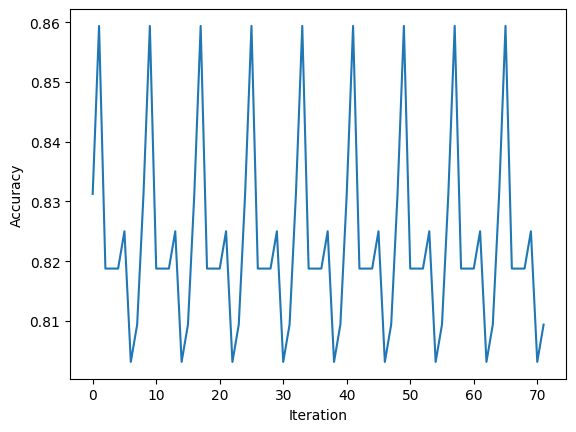

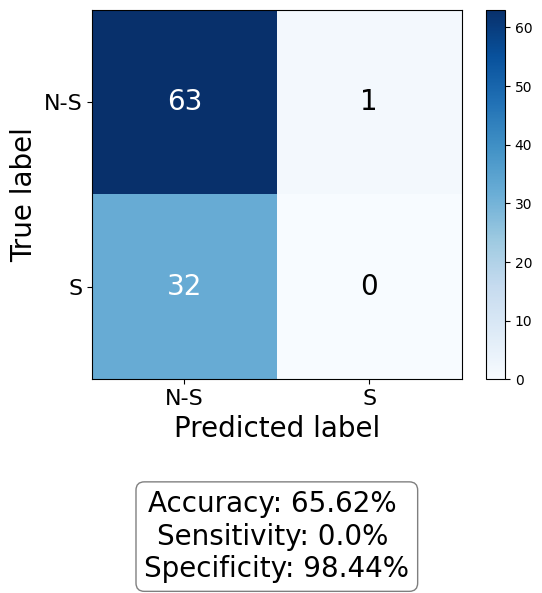

In [22]:
print(f'{data_type} data with {feature_type} features and {label_type} labels')
clfs.knn_classification(train_data, test_data, train_labels, test_labels)

init data with <function time_series_features at 0x13a321e10> features and pss labels
SVC(C=1000)
{'C': 1000, 'kernel': 'rbf'}
Number of results: 40
accuracies: [0.828125 0.775    0.775    0.775    0.840625 0.775    0.775    0.775
 0.840625 0.775    0.775    0.775    0.840625 0.775    0.775    0.75625
 0.840625 0.771875 0.775    0.6875   0.840625 0.76875  0.809375 0.634375
 0.840625 0.7625   0.859375 0.61875  0.840625 0.76875  0.853125 0.621875
 0.840625 0.778125 0.853125 0.621875 0.840625 0.765625 0.853125 0.621875]


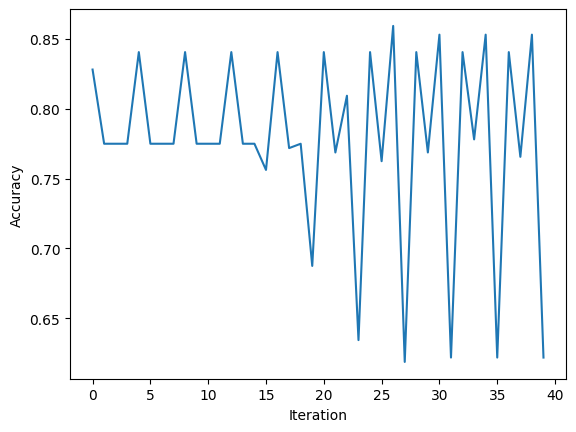

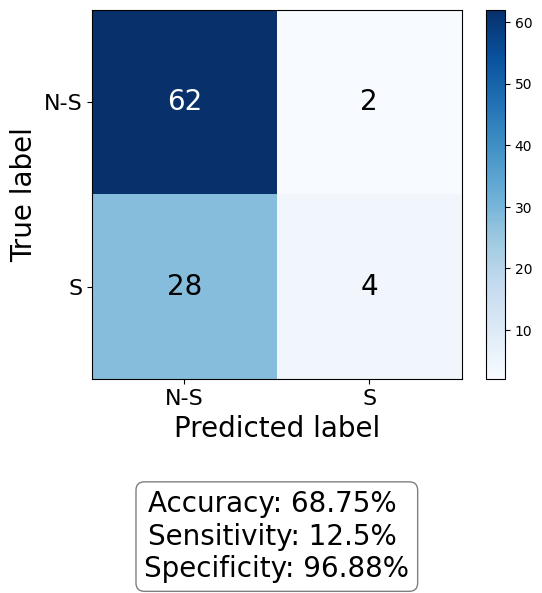

In [23]:
print(f'{data_type} data with {feature_type} features and {label_type} labels')
clfs.svm_classification(train_data, test_data, train_labels, test_labels)


In [24]:
#time_series_features, fractal_features, entropy_features, hjorth_features, freq_band_features, kymatio_wave_scattering
feature_type = f.fractal_features
kfold = True


train_data, test_data, train_labels, test_labels = ld.load_and_shape_data(data_type, label_type, feature_type, kfold)

---- Generating all recordings ----
All records generated

---- Filtering out invalid recordings ----
ERROR 1) Failed to read data for recording P006_S002_001
ERROR 1) Failed to read data for recording P006_S002_002
ERROR 1) Failed to read data for recording P010_S001_001
ERROR 1) Failed to read data for recording P013_S001_001
ERROR 1) Failed to read data for recording P013_S001_002
ERROR 1) Failed to read data for recording P020_S001_001
ERROR 1) Failed to read data for recording P023_S002_002
ERROR 1) Failed to read data for recording P028_S002_001
ERROR 1) Failed to read data for recording P028_S002_002

---- Returning valid recordings ----
['P001_S001_001', 'P001_S001_002', 'P001_S002_001', 'P001_S002_002', 'P002_S001_001', 'P002_S001_002', 'P002_S002_001', 'P002_S002_002', 'P003_S001_001', 'P003_S001_002', 'P003_S002_001', 'P003_S002_002', 'P004_S001_001', 'P004_S001_002', 'P004_S002_001', 'P004_S002_002', 'P005_S001_001', 'P005_S001_002', 'P005_S002_001', 'P005_S002_002', 'P006_

init data with <function fractal_features at 0x13a39dcf0> features and pss labels
KNeighborsClassifier(leaf_size=1, n_neighbors=2)
{'leaf_size': 1, 'n_neighbors': 2, 'p': 2}
Number of results: 72
accuracies: [0.684375 0.69375  0.771875 0.775    0.721875 0.725    0.7375   0.75625
 0.684375 0.69375  0.771875 0.775    0.721875 0.725    0.7375   0.75625
 0.684375 0.69375  0.771875 0.775    0.721875 0.725    0.7375   0.75625
 0.684375 0.69375  0.771875 0.775    0.721875 0.725    0.7375   0.75625
 0.684375 0.69375  0.771875 0.775    0.721875 0.725    0.7375   0.75625
 0.684375 0.69375  0.771875 0.775    0.721875 0.725    0.7375   0.75625
 0.684375 0.69375  0.771875 0.775    0.721875 0.725    0.7375   0.75625
 0.684375 0.69375  0.771875 0.775    0.721875 0.725    0.7375   0.75625
 0.684375 0.69375  0.771875 0.775    0.721875 0.725    0.7375   0.75625 ]


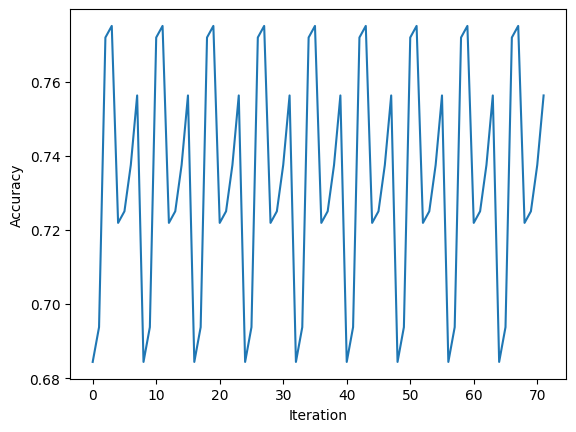

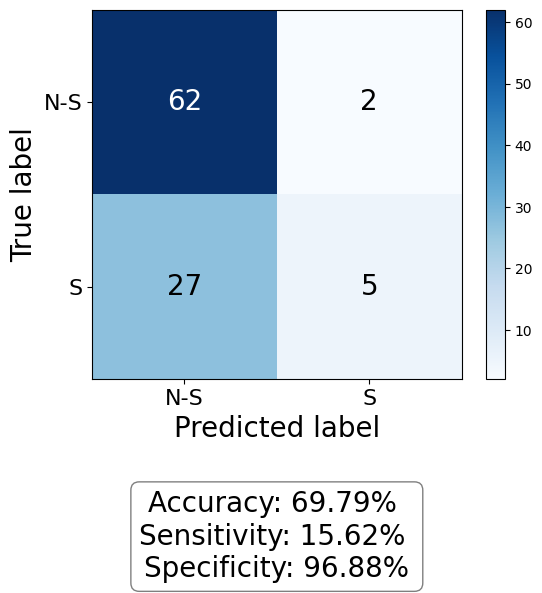

In [25]:
print(f'{data_type} data with {feature_type} features and {label_type} labels')
clfs.knn_classification(train_data, test_data, train_labels, test_labels)

init data with <function fractal_features at 0x13a39dcf0> features and pss labels
SVC(C=100)
{'C': 100, 'kernel': 'rbf'}
Number of results: 40
accuracies: [0.775    0.775    0.775    0.775    0.778125 0.775    0.775    0.775
 0.7875   0.775    0.775    0.775    0.759375 0.7625   0.775    0.76875
 0.759375 0.7625   0.784375 0.721875 0.759375 0.78125  0.834375 0.690625
 0.759375 0.75     0.834375 0.690625 0.759375 0.70625  0.834375 0.690625
 0.759375 0.709375 0.834375 0.690625 0.759375 0.709375 0.834375 0.690625]


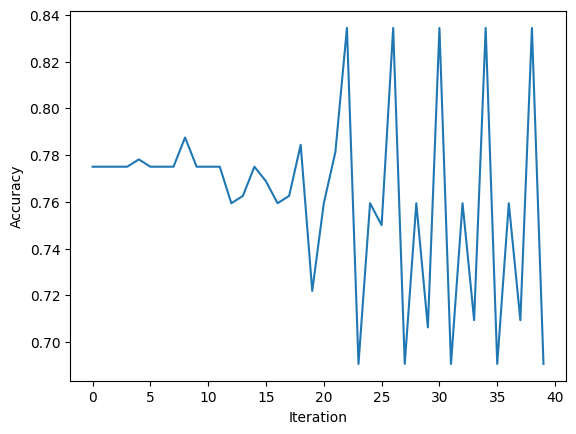

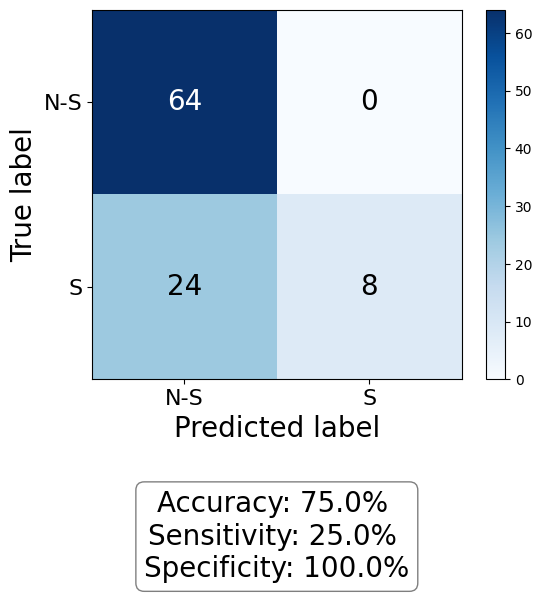

In [26]:
print(f'{data_type} data with {feature_type} features and {label_type} labels')
clfs.svm_classification(train_data, test_data, train_labels, test_labels)


In [27]:
#time_series_features, fractal_features, entropy_features, hjorth_features, freq_band_features, kymatio_wave_scattering
feature_type = f.entropy_features
kfold = True


train_data, test_data, train_labels, test_labels = ld.load_and_shape_data(data_type, label_type, feature_type, kfold)

---- Generating all recordings ----
All records generated

---- Filtering out invalid recordings ----
ERROR 1) Failed to read data for recording P006_S002_001
ERROR 1) Failed to read data for recording P006_S002_002
ERROR 1) Failed to read data for recording P010_S001_001
ERROR 1) Failed to read data for recording P013_S001_001
ERROR 1) Failed to read data for recording P013_S001_002
ERROR 1) Failed to read data for recording P020_S001_001
ERROR 1) Failed to read data for recording P023_S002_002
ERROR 1) Failed to read data for recording P028_S002_001
ERROR 1) Failed to read data for recording P028_S002_002

---- Returning valid recordings ----
['P001_S001_001', 'P001_S001_002', 'P001_S002_001', 'P001_S002_002', 'P002_S001_001', 'P002_S001_002', 'P002_S002_001', 'P002_S002_002', 'P003_S001_001', 'P003_S001_002', 'P003_S002_001', 'P003_S002_002', 'P004_S001_001', 'P004_S001_002', 'P004_S002_001', 'P004_S002_002', 'P005_S001_001', 'P005_S001_002', 'P005_S002_001', 'P005_S002_002', 'P006_

init data with <function entropy_features at 0x13c357910> features and pss labels
KNeighborsClassifier(leaf_size=1, n_neighbors=4, p=1)
{'leaf_size': 1, 'n_neighbors': 4, 'p': 1}
Number of results: 72
accuracies: [0.7      0.728125 0.78125  0.778125 0.778125 0.7625   0.7875   0.778125
 0.7      0.728125 0.78125  0.778125 0.778125 0.7625   0.7875   0.778125
 0.7      0.728125 0.78125  0.778125 0.778125 0.7625   0.7875   0.778125
 0.7      0.728125 0.78125  0.778125 0.778125 0.7625   0.7875   0.778125
 0.7      0.728125 0.78125  0.778125 0.778125 0.7625   0.7875   0.778125
 0.7      0.728125 0.78125  0.778125 0.778125 0.7625   0.7875   0.778125
 0.7      0.728125 0.78125  0.778125 0.778125 0.7625   0.7875   0.778125
 0.7      0.728125 0.78125  0.778125 0.778125 0.7625   0.7875   0.778125
 0.7      0.728125 0.78125  0.778125 0.778125 0.7625   0.7875   0.778125]


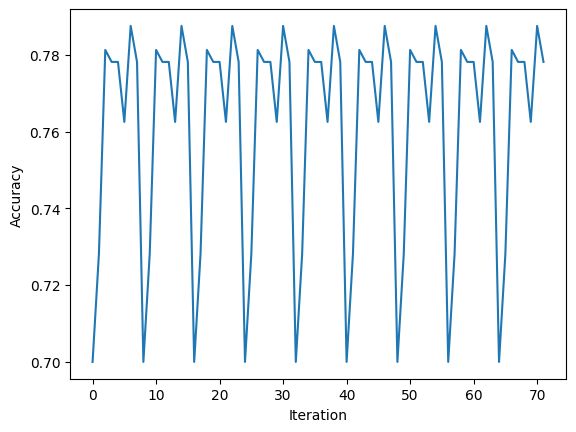

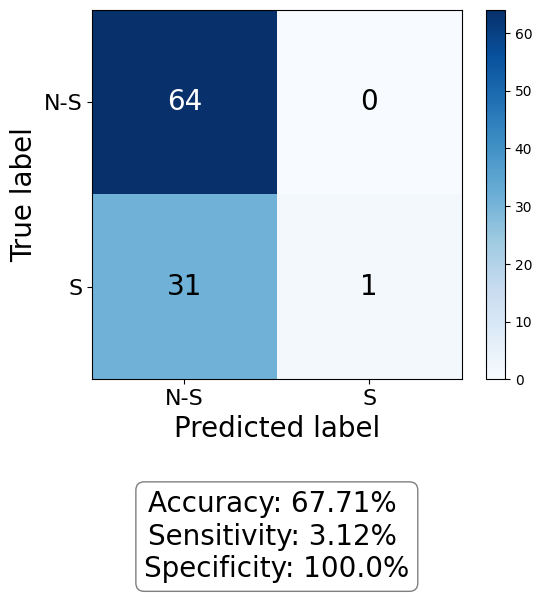

In [28]:
print(f'{data_type} data with {feature_type} features and {label_type} labels')
clfs.knn_classification(train_data, test_data, train_labels, test_labels)

init data with <function entropy_features at 0x13c357910> features and pss labels
SVC(C=0.01, kernel='linear')
{'C': 0.01, 'kernel': 'linear'}
Number of results: 40
accuracies: [0.778125 0.775    0.775    0.775    0.846875 0.775    0.775    0.775
 0.815625 0.771875 0.775    0.775    0.809375 0.76875  0.790625 0.721875
 0.809375 0.78125  0.834375 0.66875  0.809375 0.796875 0.83125  0.665625
 0.809375 0.796875 0.83125  0.665625 0.809375 0.796875 0.83125  0.665625
 0.809375 0.796875 0.83125  0.665625 0.809375 0.796875 0.83125  0.665625]


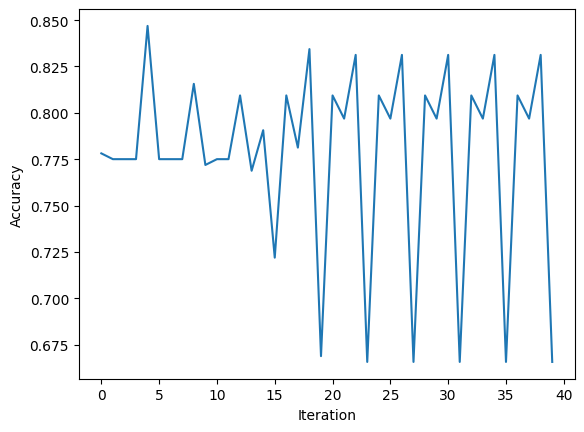

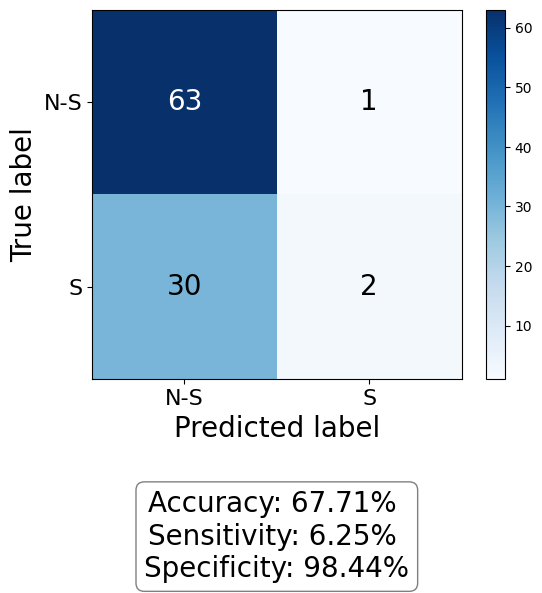

In [29]:
print(f'{data_type} data with {feature_type} features and {label_type} labels')
clfs.svm_classification(train_data, test_data, train_labels, test_labels)


In [30]:
#time_series_features, fractal_features, entropy_features, hjorth_features, freq_band_features, kymatio_wave_scattering
feature_type = f.hjorth_features
kfold = True


train_data, test_data, train_labels, test_labels = ld.load_and_shape_data(data_type, label_type, feature_type, kfold)

---- Generating all recordings ----
All records generated

---- Filtering out invalid recordings ----
ERROR 1) Failed to read data for recording P006_S002_001
ERROR 1) Failed to read data for recording P006_S002_002
ERROR 1) Failed to read data for recording P010_S001_001
ERROR 1) Failed to read data for recording P013_S001_001
ERROR 1) Failed to read data for recording P013_S001_002
ERROR 1) Failed to read data for recording P020_S001_001
ERROR 1) Failed to read data for recording P023_S002_002
ERROR 1) Failed to read data for recording P028_S002_001
ERROR 1) Failed to read data for recording P028_S002_002

---- Returning valid recordings ----
['P001_S001_001', 'P001_S001_002', 'P001_S002_001', 'P001_S002_002', 'P002_S001_001', 'P002_S001_002', 'P002_S002_001', 'P002_S002_002', 'P003_S001_001', 'P003_S001_002', 'P003_S002_001', 'P003_S002_002', 'P004_S001_001', 'P004_S001_002', 'P004_S002_001', 'P004_S002_002', 'P005_S001_001', 'P005_S001_002', 'P005_S002_001', 'P005_S002_002', 'P006_

init data with <function hjorth_features at 0x13c3579a0> features and pss labels
KNeighborsClassifier(leaf_size=1, n_neighbors=1)
{'leaf_size': 1, 'n_neighbors': 1, 'p': 2}
Number of results: 72
accuracies: [0.8      0.9      0.778125 0.878125 0.778125 0.878125 0.778125 0.878125
 0.8      0.9      0.778125 0.878125 0.778125 0.878125 0.778125 0.878125
 0.8      0.9      0.778125 0.878125 0.778125 0.878125 0.778125 0.878125
 0.8      0.9      0.778125 0.878125 0.778125 0.878125 0.778125 0.878125
 0.8      0.9      0.778125 0.878125 0.778125 0.878125 0.778125 0.878125
 0.8      0.9      0.778125 0.878125 0.778125 0.878125 0.778125 0.878125
 0.8      0.9      0.778125 0.878125 0.778125 0.878125 0.778125 0.878125
 0.8      0.9      0.778125 0.878125 0.778125 0.878125 0.778125 0.878125
 0.8      0.9      0.778125 0.878125 0.778125 0.878125 0.778125 0.878125]


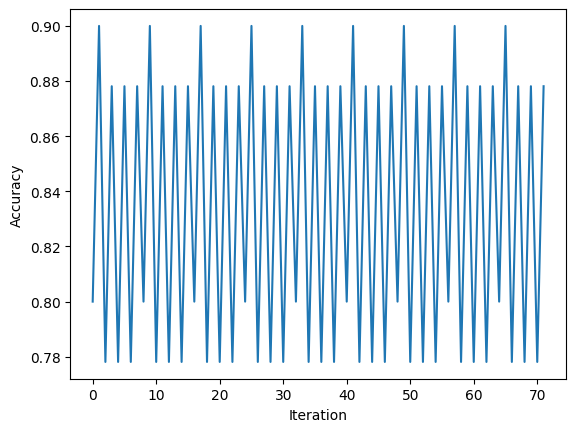

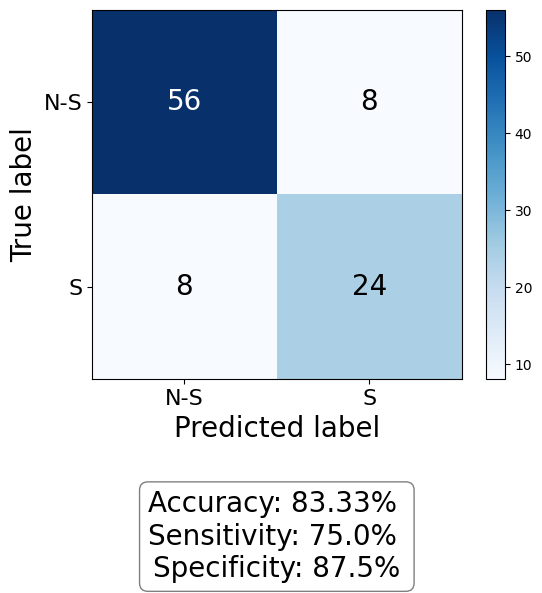

In [31]:
print(f'{data_type} data with {feature_type} features and {label_type} labels')
clfs.knn_classification(train_data, test_data, train_labels, test_labels)

init data with <function hjorth_features at 0x13c3579a0> features and pss labels
SVC(C=10000)
{'C': 10000, 'kernel': 'rbf'}
Number of results: 40
accuracies: [0.775    0.75     0.775    0.775    0.775    0.75     0.775    0.775
 0.75     0.775    0.775    0.75     0.803125 0.775    0.75     0.75
 0.8      0.775    0.75     0.75     0.775    0.775    0.75     0.625
 0.7      0.775    0.75     0.625    0.6875   0.775    0.825    0.625
 0.70625  0.775    0.825    0.625    0.71875  0.75     0.8      0.625   ]


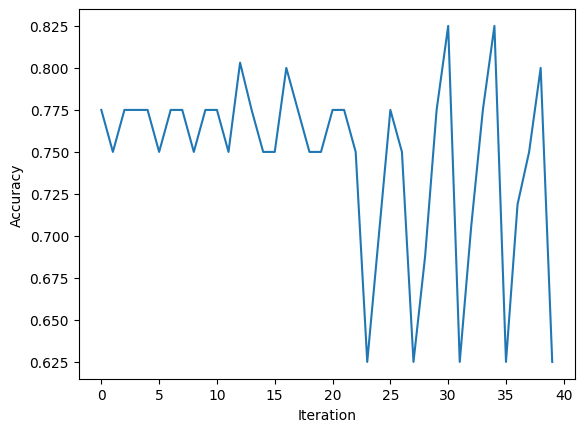

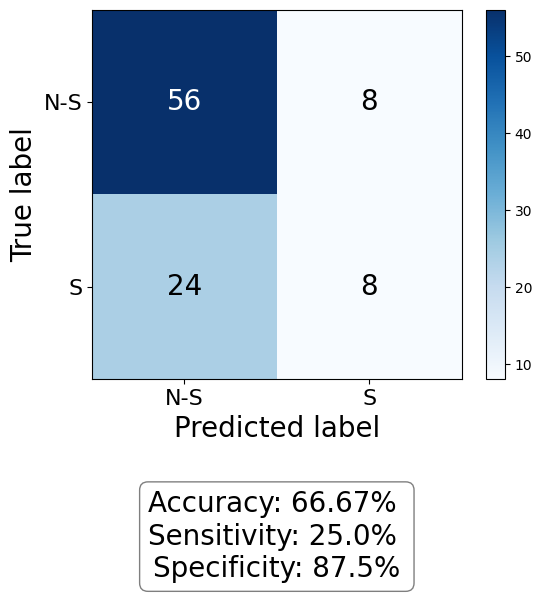

In [32]:
print(f'{data_type} data with {feature_type} features and {label_type} labels')
clfs.svm_classification(train_data, test_data, train_labels, test_labels)


In [33]:
#time_series_features, fractal_features, entropy_features, hjorth_features, freq_band_features, kymatio_wave_scattering
feature_type = f.freq_band_features
kfold = True


train_data, test_data, train_labels, test_labels = ld.load_and_shape_data(data_type, label_type, feature_type, kfold)

---- Generating all recordings ----
All records generated

---- Filtering out invalid recordings ----
ERROR 1) Failed to read data for recording P006_S002_001
ERROR 1) Failed to read data for recording P006_S002_002
ERROR 1) Failed to read data for recording P010_S001_001
ERROR 1) Failed to read data for recording P013_S001_001
ERROR 1) Failed to read data for recording P013_S001_002
ERROR 1) Failed to read data for recording P020_S001_001
ERROR 1) Failed to read data for recording P023_S002_002
ERROR 1) Failed to read data for recording P028_S002_001
ERROR 1) Failed to read data for recording P028_S002_002

---- Returning valid recordings ----
['P001_S001_001', 'P001_S001_002', 'P001_S002_001', 'P001_S002_002', 'P002_S001_001', 'P002_S001_002', 'P002_S002_001', 'P002_S002_002', 'P003_S001_001', 'P003_S001_002', 'P003_S002_001', 'P003_S002_002', 'P004_S001_001', 'P004_S001_002', 'P004_S002_001', 'P004_S002_002', 'P005_S001_001', 'P005_S001_002', 'P005_S002_001', 'P005_S002_002', 'P006_

init data with <function freq_band_features at 0x13c357a30> features and pss labels
KNeighborsClassifier(leaf_size=1, n_neighbors=4)
{'leaf_size': 1, 'n_neighbors': 4, 'p': 2}
Number of results: 72
accuracies: [0.71875  0.7125   0.715625 0.709375 0.74375  0.725    0.75     0.78125
 0.71875  0.7125   0.715625 0.709375 0.74375  0.725    0.75     0.78125
 0.71875  0.7125   0.715625 0.709375 0.74375  0.725    0.75     0.78125
 0.71875  0.7125   0.715625 0.709375 0.74375  0.725    0.75     0.78125
 0.71875  0.7125   0.715625 0.709375 0.74375  0.725    0.75     0.78125
 0.71875  0.7125   0.715625 0.709375 0.74375  0.725    0.75     0.78125
 0.71875  0.7125   0.715625 0.709375 0.74375  0.725    0.75     0.78125
 0.71875  0.7125   0.715625 0.709375 0.74375  0.725    0.75     0.78125
 0.71875  0.7125   0.715625 0.709375 0.74375  0.725    0.75     0.78125 ]


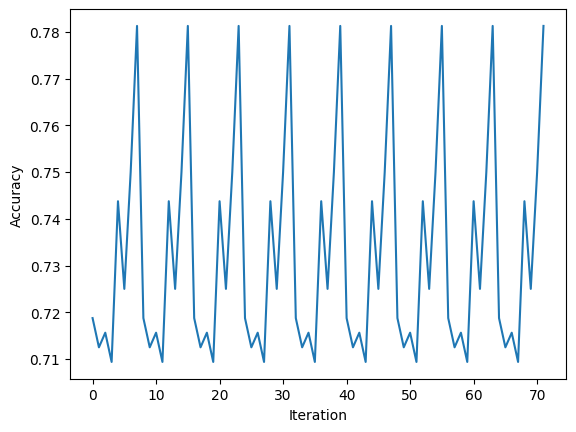

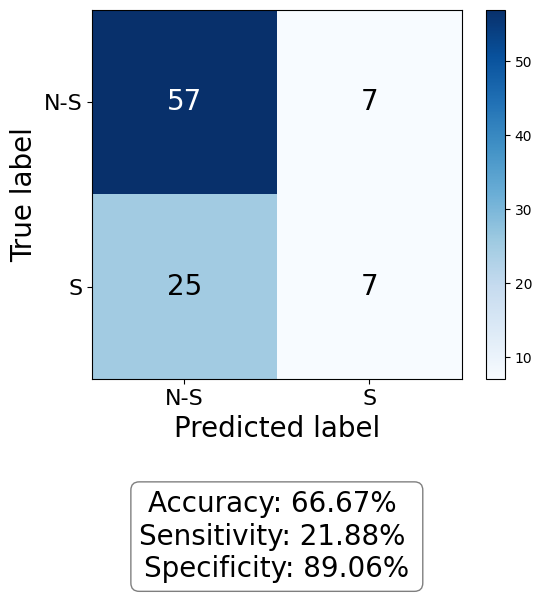

In [34]:
print(f'{data_type} data with {feature_type} features and {label_type} labels')
clfs.knn_classification(train_data, test_data, train_labels, test_labels)

init data with <function freq_band_features at 0x13c357a30> features and pss labels
SVC(C=1, kernel='sigmoid')
{'C': 1, 'kernel': 'sigmoid'}
Number of results: 40
accuracies: [0.734375 0.775    0.775    0.775    0.765625 0.775    0.775    0.775
 0.721875 0.775    0.775    0.775    0.721875 0.746875 0.721875 0.828125
 0.721875 0.7625   0.728125 0.771875 0.721875 0.759375 0.728125 0.775
 0.721875 0.753125 0.728125 0.7625   0.721875 0.759375 0.728125 0.746875
 0.721875 0.759375 0.728125 0.775    0.721875 0.759375 0.728125 0.778125]


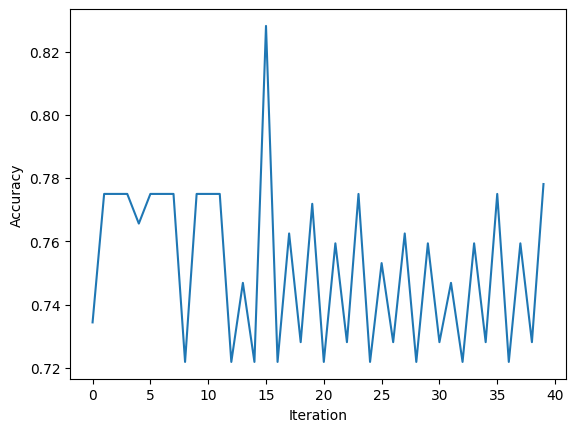

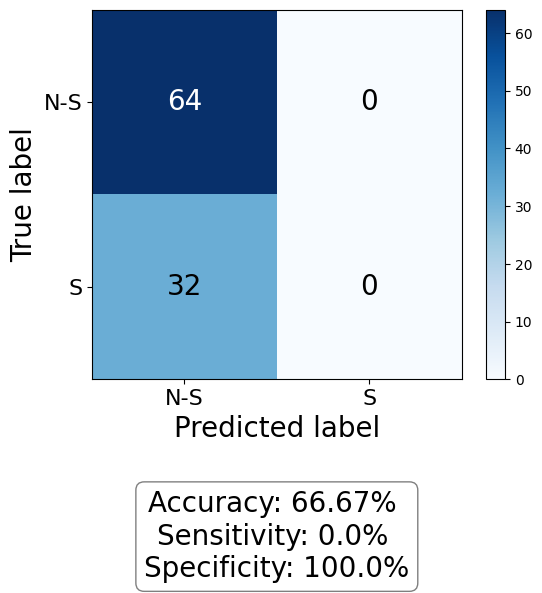

In [35]:
print(f'{data_type} data with {feature_type} features and {label_type} labels')
clfs.svm_classification(train_data, test_data, train_labels, test_labels)


In [36]:
#time_series_features, fractal_features, entropy_features, hjorth_features, freq_band_features, kymatio_wave_scattering
feature_type = None
kfold = True


train_data, test_data, train_labels, test_labels = ld.load_and_shape_data(data_type, label_type, feature_type, kfold)

---- Generating all recordings ----
All records generated

---- Filtering out invalid recordings ----
ERROR 1) Failed to read data for recording P006_S002_001
ERROR 1) Failed to read data for recording P006_S002_002
ERROR 1) Failed to read data for recording P010_S001_001
ERROR 1) Failed to read data for recording P013_S001_001
ERROR 1) Failed to read data for recording P013_S001_002
ERROR 1) Failed to read data for recording P020_S001_001
ERROR 1) Failed to read data for recording P023_S002_002
ERROR 1) Failed to read data for recording P028_S002_001
ERROR 1) Failed to read data for recording P028_S002_002

---- Returning valid recordings ----
['P001_S001_001', 'P001_S001_002', 'P001_S002_001', 'P001_S002_002', 'P002_S001_001', 'P002_S001_002', 'P002_S002_001', 'P002_S002_002', 'P003_S001_001', 'P003_S001_002', 'P003_S002_001', 'P003_S002_002', 'P004_S001_001', 'P004_S001_002', 'P004_S002_001', 'P004_S002_002', 'P005_S001_001', 'P005_S001_002', 'P005_S002_001', 'P005_S002_002', 'P006_

KNeighborsClassifier(leaf_size=1, n_neighbors=1, p=1)
{'leaf_size': 1, 'n_neighbors': 1, 'p': 1}
Number of results: 72
accuracies: [0.875    0.871875 0.834375 0.834375 0.834375 0.834375 0.81875  0.809375
 0.875    0.871875 0.834375 0.834375 0.834375 0.834375 0.81875  0.809375
 0.875    0.871875 0.834375 0.834375 0.834375 0.834375 0.81875  0.809375
 0.875    0.871875 0.834375 0.834375 0.834375 0.834375 0.81875  0.809375
 0.875    0.871875 0.834375 0.834375 0.834375 0.834375 0.81875  0.809375
 0.875    0.871875 0.834375 0.834375 0.834375 0.834375 0.81875  0.809375
 0.875    0.871875 0.834375 0.834375 0.834375 0.834375 0.81875  0.809375
 0.875    0.871875 0.834375 0.834375 0.834375 0.834375 0.81875  0.809375
 0.875    0.871875 0.834375 0.834375 0.834375 0.834375 0.81875  0.809375]


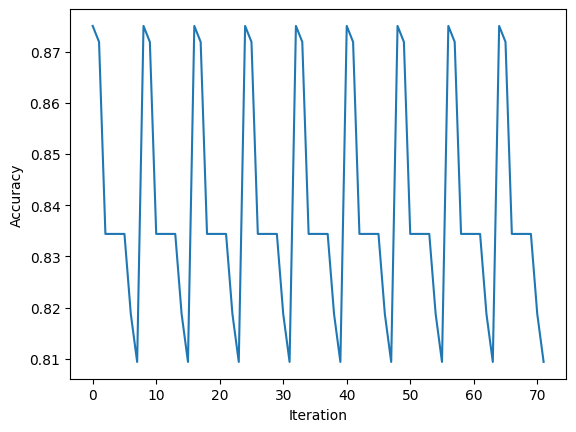

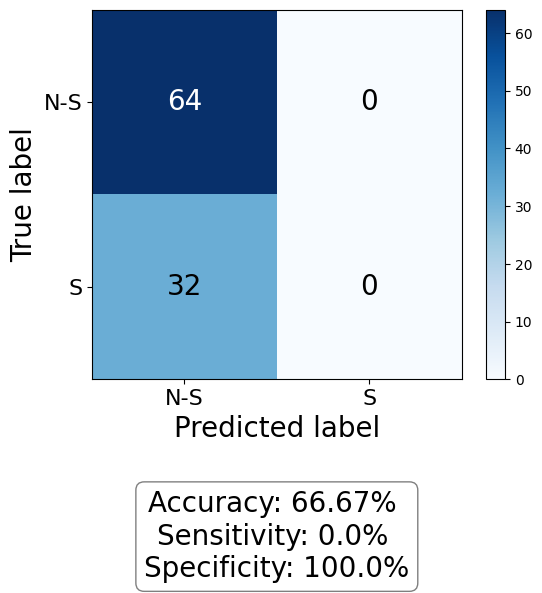

In [37]:
#print(f'{data_type} data with {feature_type} features and {label_type} labels')
clfs.knn_classification(train_data, test_data, train_labels, test_labels)

/Users/AnneJoo/.local/share/virtualenvs/MASTER-eeg-stress-det-zSpBlwVN/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


SVC(C=10)
{'C': 10, 'kernel': 'rbf'}
Number of results: 40
accuracies: [0.84375  0.775    0.775    0.775    0.84375  0.775    0.775    0.775
 0.84375  0.775    0.775    0.775    0.84375  0.784375 0.78125  0.803125
 0.84375  0.79375  0.859375 0.76875  0.84375  0.809375 0.859375 0.73125
 0.84375  0.815625 0.859375 0.721875 0.84375  0.8375   0.859375 0.721875
 0.84375  0.8375   0.859375 0.721875 0.84375  0.8375   0.859375 0.721875]


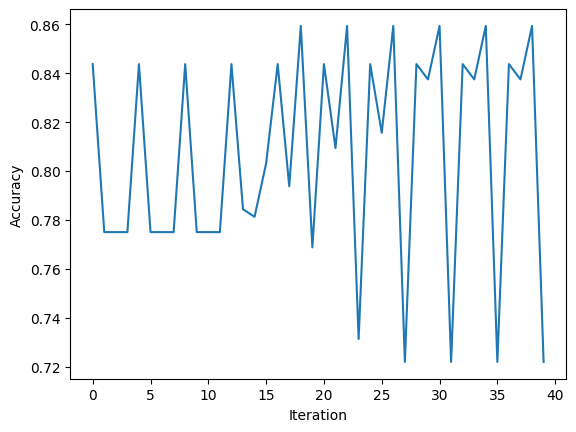

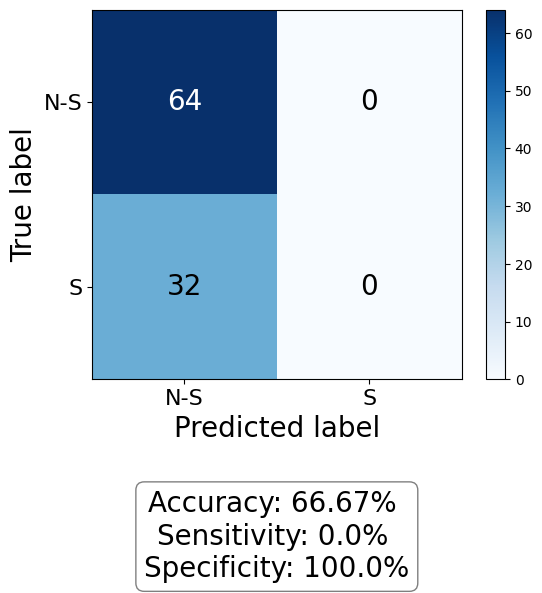

In [38]:
#print(f'{data_type} data with {feature_type} features and {label_type} labels')
clfs.svm_classification(train_data, test_data, train_labels, test_labels)